In [9]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)

In [13]:
obj = readRDS('ds_obj.rds')
# obj = qs::qread('ds_obj.qs')
obj

An object of class Seurat 
54134 features across 10000 samples within 3 assays 
Active assay: SCT (21813 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [14]:
sce = as.SingleCellExperiment(obj)
sce

class: SingleCellExperiment 
dim: 21813 10000 
metadata(0):
assays(2): counts logcounts
rownames(21813): Lypla1 Tcea1 ... ENSMUSG00000095742 ENSMUSG00000095041
rowData names(0):
colnames(10000): GATGCTAAGTCACGAG_1_1 GTACAGTGTCGGTGAA_3_2 ...
  ATCTTCAAGTGGACGT_1_2 GTTGCGGCACAAGTGG_5_3
colData names(9): hash.mcl.ID batch ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
mainExpName: SCT
altExpNames(2): RNA integrated

In [30]:
milo <- Milo(sce)

#build KNN graph
milo <- buildGraph(milo, k=40, d=30, reduced.dim = 'PCA')

#define neighbourhoods
milo <- makeNhoods(milo, prop = 0.1, k= 40, d=30, refined = T, reduced_dims = 'PCA')

Constructing kNN graph with k:40

Checking valid object

Running refined sampling with reduced_dim



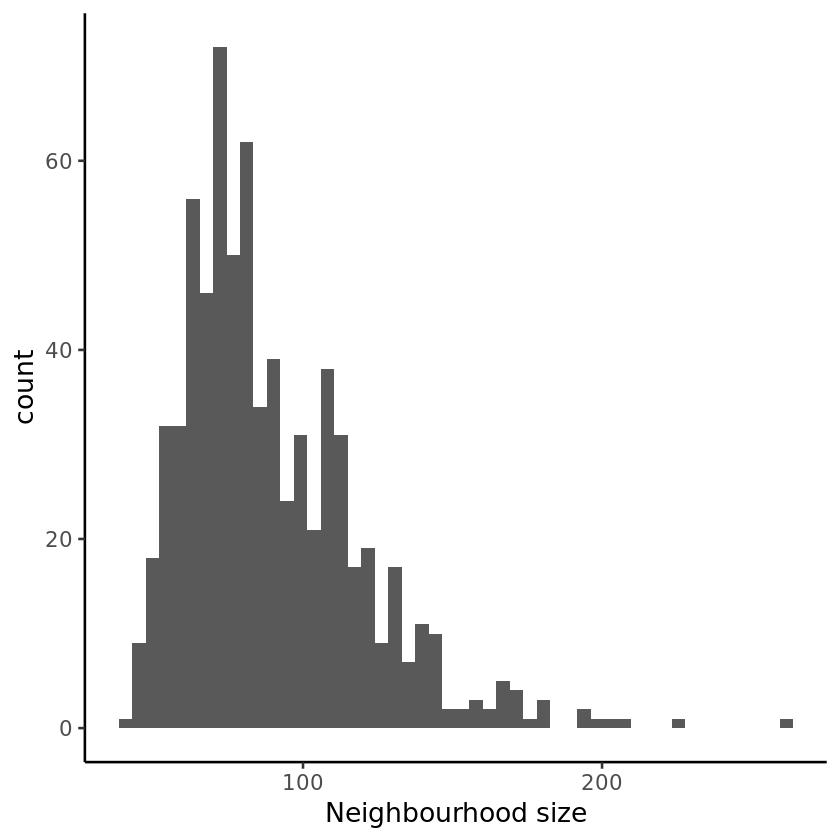

In [31]:
#plot neighbourhood sizes to check if we used appropriate k for graph building
  #we want to have an average size over 5 x N_samples
  #we have 171 samples - but not all samples will be in all neighbourhoods because of age variance
plotNhoodSizeHist(milo)

Checking meta.data validity

Counting cells in neighbourhoods



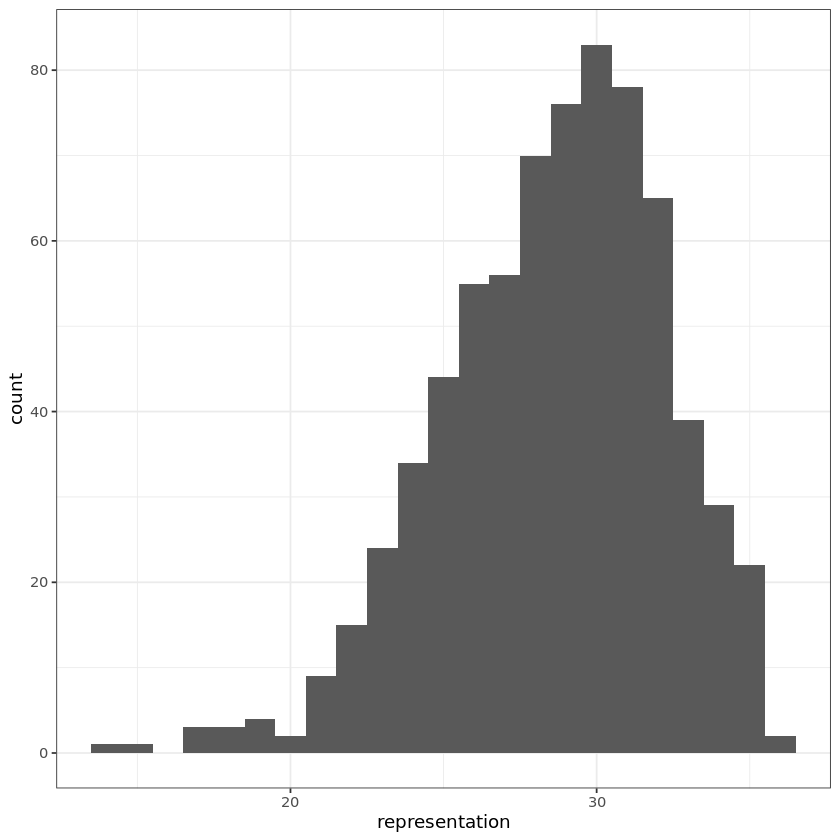

In [32]:
#add a n x m matrix to the milo object with number of neighbourhodds and samples
milo <- countCells(milo, meta.data = as.data.frame(colData(milo)), sample = 'hash.mcl.ID')

#calculate sample representation in each neighbourhood
cell_counts <- as.data.frame(nhoodCounts(milo)) %>% mutate(representation = rowSums(.>0))

#view distribution of N_samples in each neigbourhood
ggplot(cell_counts, aes(x = representation)) + 
  geom_histogram(binwidth = 1) + theme_bw()

#most neighbourhoods have 30-60 samples in them

In [33]:
design_df <- data.frame(colData(milo))[, c('hash.mcl.ID', 'group', 'batch')]
#convert seq-pool to factor
design_df$batch <- as.factor(design_df$batch)
#keep unique rows
design_df <- distinct(design_df)
#change rownames
rownames(design_df) <- design_df$hash.mcl.ID
head(design_df)

,hash.mcl.ID,group,batch
,<chr>,<fct>,<fct>
M17,M17,P0.T2.S0,Batch__1
M25,M25,P0.T2.S1,Batch__2
N21,N21,P1.T1.S1,Batch__3
M24,M24,P0.T2.S1,Batch__1
M11,M11,P0.T1.S1,Batch__2
M18,M18,P0.T2.S0,Batch__1


In [34]:
levels(design_df$group)

[1] "P0.T2.S0" "P0.T1.S0" "P1.T2.S1" "P0.T2.S1" "P1.T1.S1" "P0.T1.S1"

In [35]:
print(design_df)

    hash.mcl.ID    group    batch
M17         M17 P0.T2.S0 Batch__1
M25         M25 P0.T2.S1 Batch__2
N21         N21 P1.T1.S1 Batch__3
M24         M24 P0.T2.S1 Batch__1
M11         M11 P0.T1.S1 Batch__2
M18         M18 P0.T2.S0 Batch__1
M19         M19 P0.T2.S0 Batch__2
N23         N23 P0.T1.S1 Batch__3
N7           N7 P1.T1.S1 Batch__1
N26         N26 P1.T1.S1 Batch__3
M4           M4 P0.T1.S0 Batch__1
M14         M14 P0.T1.S1 Batch__3
M5           M5 P0.T1.S0 Batch__2
N8           N8 P0.T1.S1 Batch__1
N17         N17 P1.T1.S1 Batch__2
J18         J18 P1.T2.S1 Batch__3
M10         M10 P1.T1.S1 Batch__2
M23         M23 P1.T2.S1 Batch__2
M28         M28 P1.T2.S1 Batch__3
J16         J16 P1.T2.S1 Batch__2
M27         M27 P1.T2.S1 Batch__2
M30         M30 P0.T2.S1 Batch__3
J7           J7 P0.T2.S1 Batch__2
M2           M2 P0.T1.S0 Batch__1
M29         M29 P0.T2.S1 Batch__2
J11         J11 P1.T2.S1 Batch__1
M13         M13 P1.T2.S1 Batch__1
M20         M20 P0.T2.S0 Batch__3
M15         M1

In [36]:
length(unique(design_df$group))

[1] 6

In [37]:
# store distances to nearest neighbours
milo <- calcNhoodDistance(milo, d=30, reduced.dim = 'PCA')
# qs::qsave(milo, 'milo.qs')
# milo = qs::qread('milo.qs')

In [38]:
# contrast.all = c("groupFGF1.Day5-groupVeh_PF.Day5")
model <- model.matrix(~0 + group + batch, data=design_df)
# mod.contrast <- makeContrasts(contrasts=contrast.all, levels=model)
head(model)

,groupP0.T2.S0,groupP0.T1.S0,groupP1.T2.S1,groupP0.T2.S1,groupP1.T1.S1,groupP0.T1.S1,batchBatch__2,batchBatch__3
M17,1,0,0,0,0,0,0,0
M25,0,0,0,1,0,0,1,0
N21,0,0,0,0,1,0,0,1
M24,0,0,0,1,0,0,0,0
M11,0,0,0,0,0,1,1,0
M18,1,0,0,0,0,0,0,0


In [39]:
options(width=120) 
print(model)

    groupP0.T2.S0 groupP0.T1.S0 groupP1.T2.S1 groupP0.T2.S1 groupP1.T1.S1 groupP0.T1.S1 batchBatch__2 batchBatch__3
M17             1             0             0             0             0             0             0             0
M25             0             0             0             1             0             0             1             0
N21             0             0             0             0             1             0             0             1
M24             0             0             0             1             0             0             0             0
M11             0             0             0             0             0             1             1             0
M18             1             0             0             0             0             0             0             0
M19             1             0             0             0             0             0             1             0
N23             0             0             0             0             

In [41]:
da_results <- testNhoods(milo, design = model, design.df = design_df, 
                         model.contrasts = c("groupP1.T1.S1-groupP0.T1.S1"))
da_results %>%
  arrange(SpatialFDR) %>%
  head()

table(da_results$FDR < 0.1)

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
448,4.507650,10.99416,36.81973,4.323534e-09,3.091327e-06,448,7.583361e-06
185,3.916137,10.98042,29.99156,9.862662e-08,3.525902e-05,185,1.070673e-04
36,5.070708,10.96427,27.81740,2.761603e-07,5.368225e-05,36,1.438778e-04
461,3.610219,10.99065,27.60653,3.003203e-07,5.368225e-05,461,1.438778e-04
486,4.070174,11.23909,21.66466,5.076360e-06,7.259195e-04,486,1.646317e-03
608,3.713627,11.07222,21.05416,6.819643e-06,8.126741e-04,608,1.737577e-03



FALSE  TRUE 
  669    46 

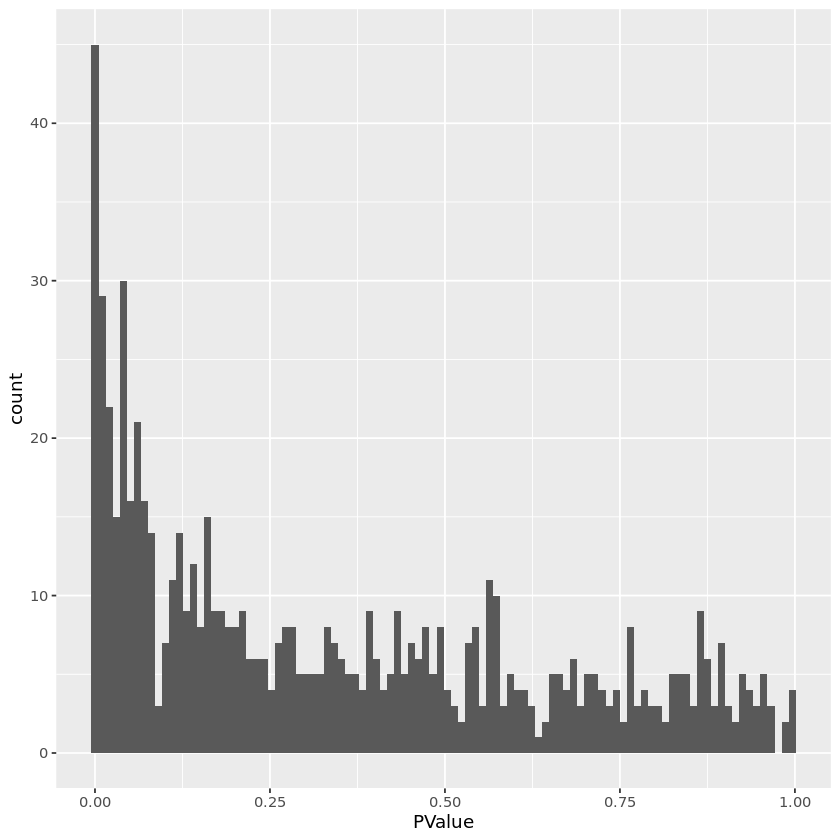

In [42]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=100)

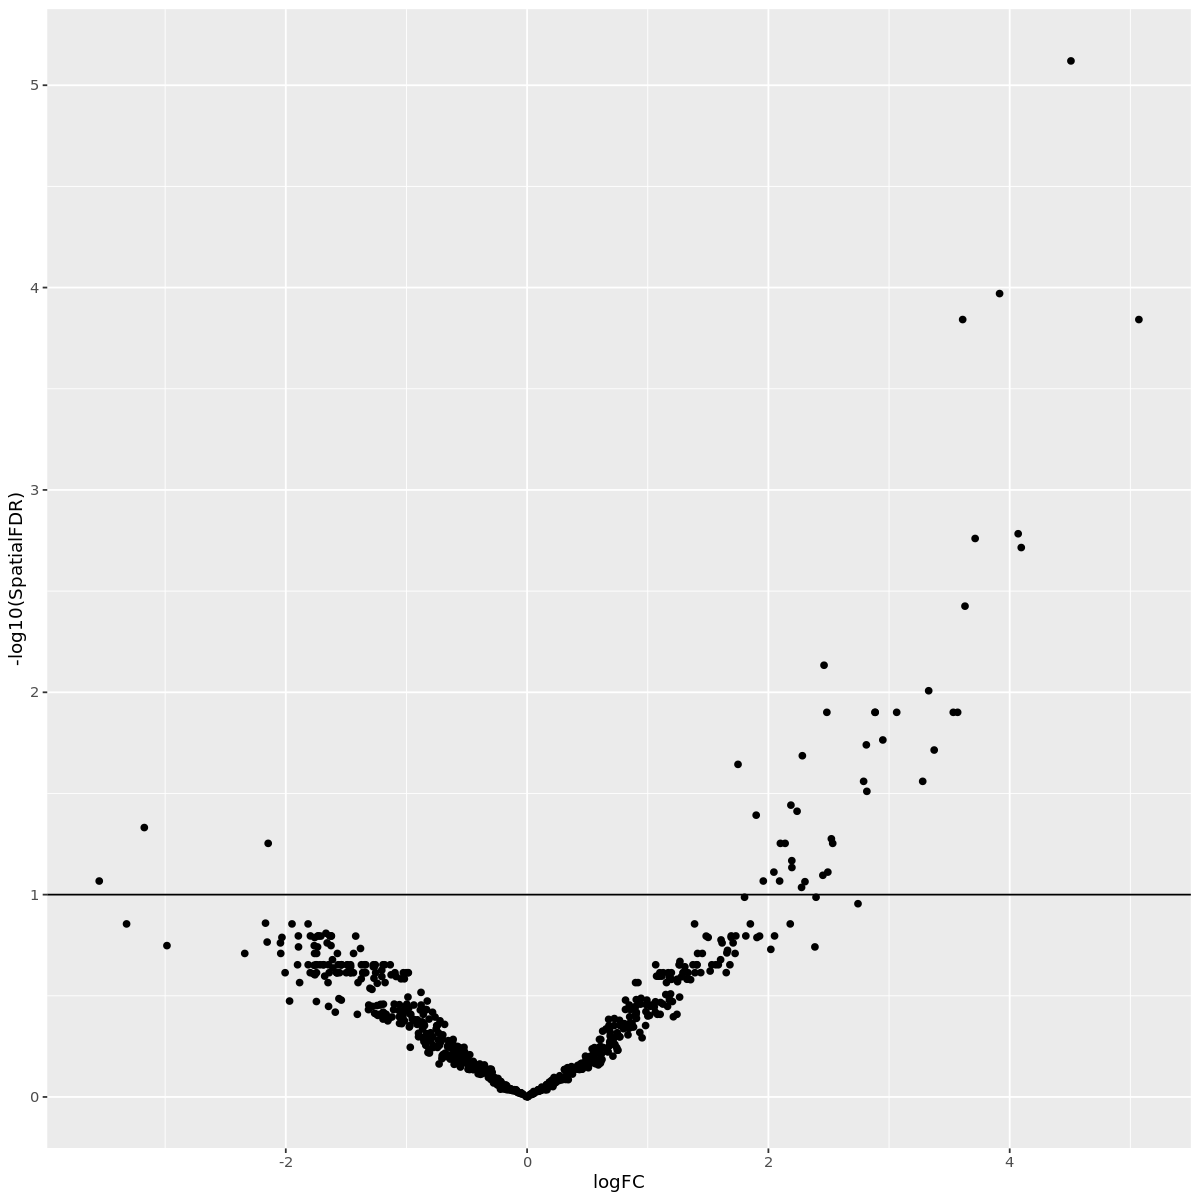

In [43]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [44]:
milo <- buildNhoodGraph(milo)

In [45]:
head(data.frame(colData(milo)))

,hash.mcl.ID,batch,group,clusters,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,ident
,<chr>,<chr>,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>
GATGCTAAGTCACGAG_1_1,M17,Batch__1,P0.T2.S0,c6,7981,3207,7,7,7
GTACAGTGTCGGTGAA_3_2,M25,Batch__2,P0.T2.S1,c1,7825,2816,1,1,1
GGTAACTTCCATAGGT_2_3,N21,Batch__3,P1.T1.S1,c12,7533,2479,14,14,14
ACGGAAGAGTGCGTCC_5_1,M24,Batch__1,P0.T2.S1,c2,6151,1529,4,4,4
CTAGACAAGCTGTTAC_2_2,M11,Batch__2,P0.T1.S1,c1,7935,2861,1,1,1
CTTACCGGTACCGGCT_5_1,M18,Batch__1,P0.T2.S0,c10,6590,2279,12,12,12


In [46]:
options(repr.plot.width=10, repr.plot.height=10)
umap_pl <- plotReducedDim(milo, dimred = "UMAP", colour_by="clusters", text_by = "clusters", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none") 

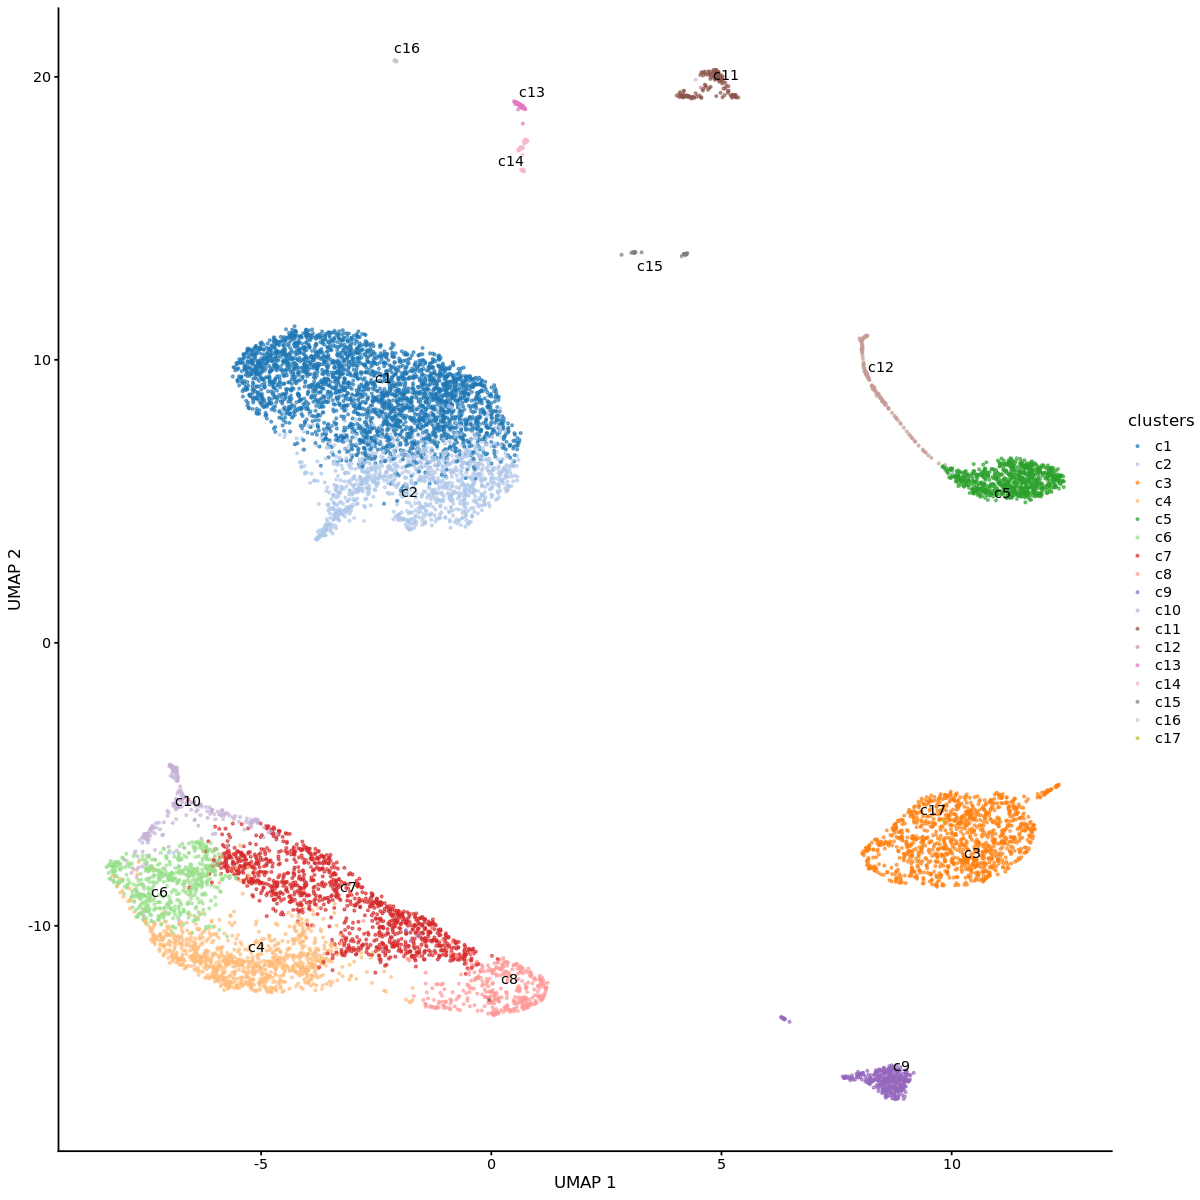

In [47]:
umap_pl

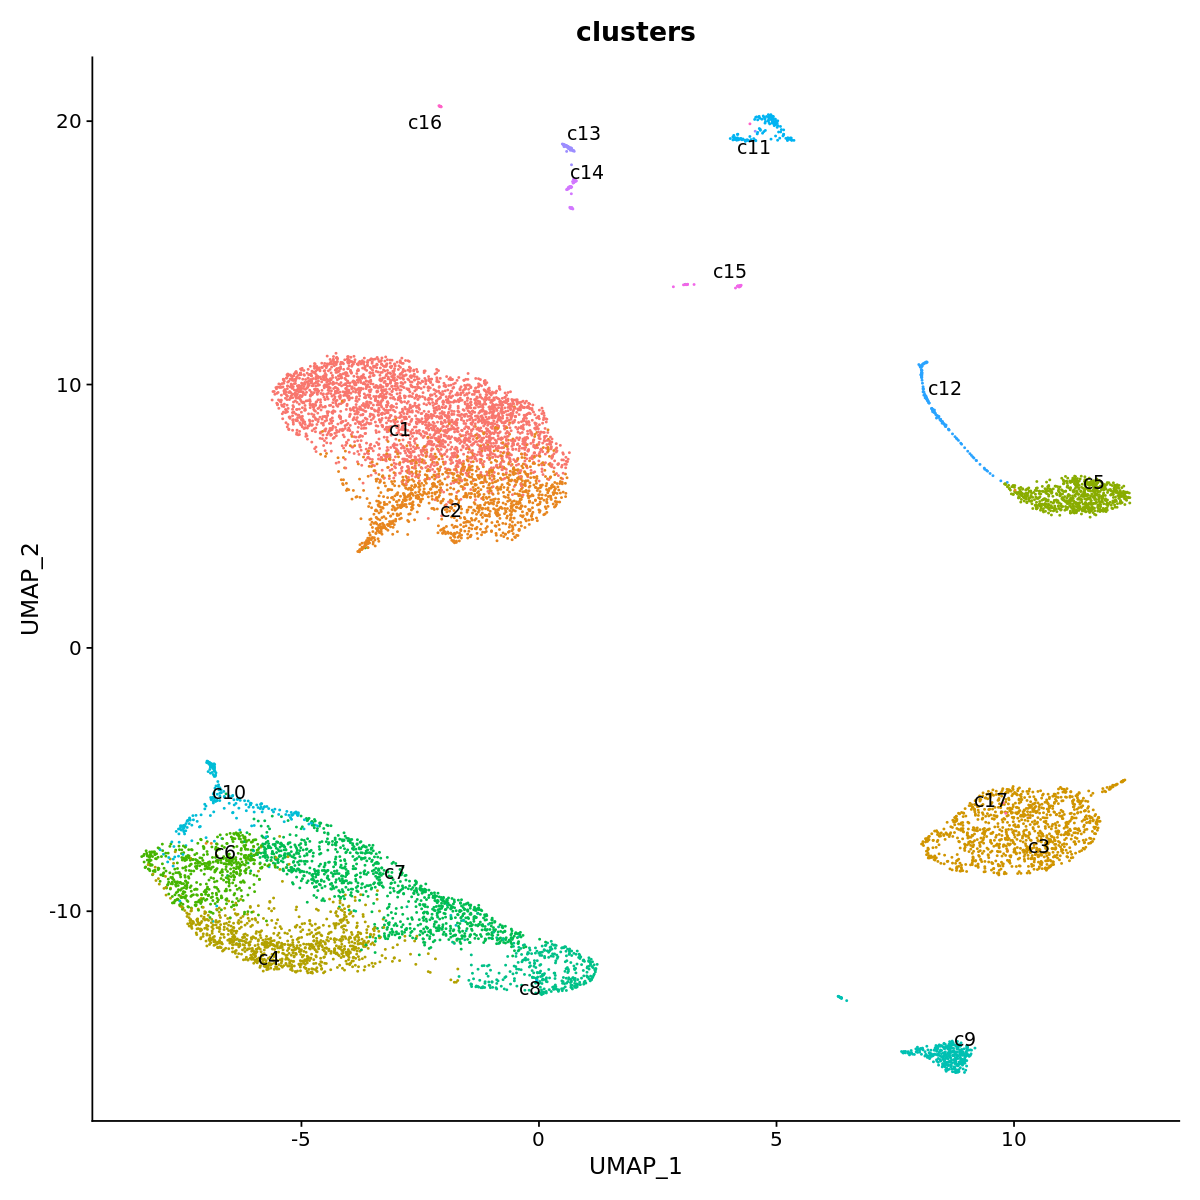

In [48]:
options(repr.plot.width=10, repr.plot.height=10)
umap_plot = DimPlot(obj, reduction = "umap", group.by = "clusters", label = TRUE,  repel = TRUE) + NoLegend()
umap_plot

In [49]:
nh_graph_pl <- plotNhoodGraphDA(milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2)) 

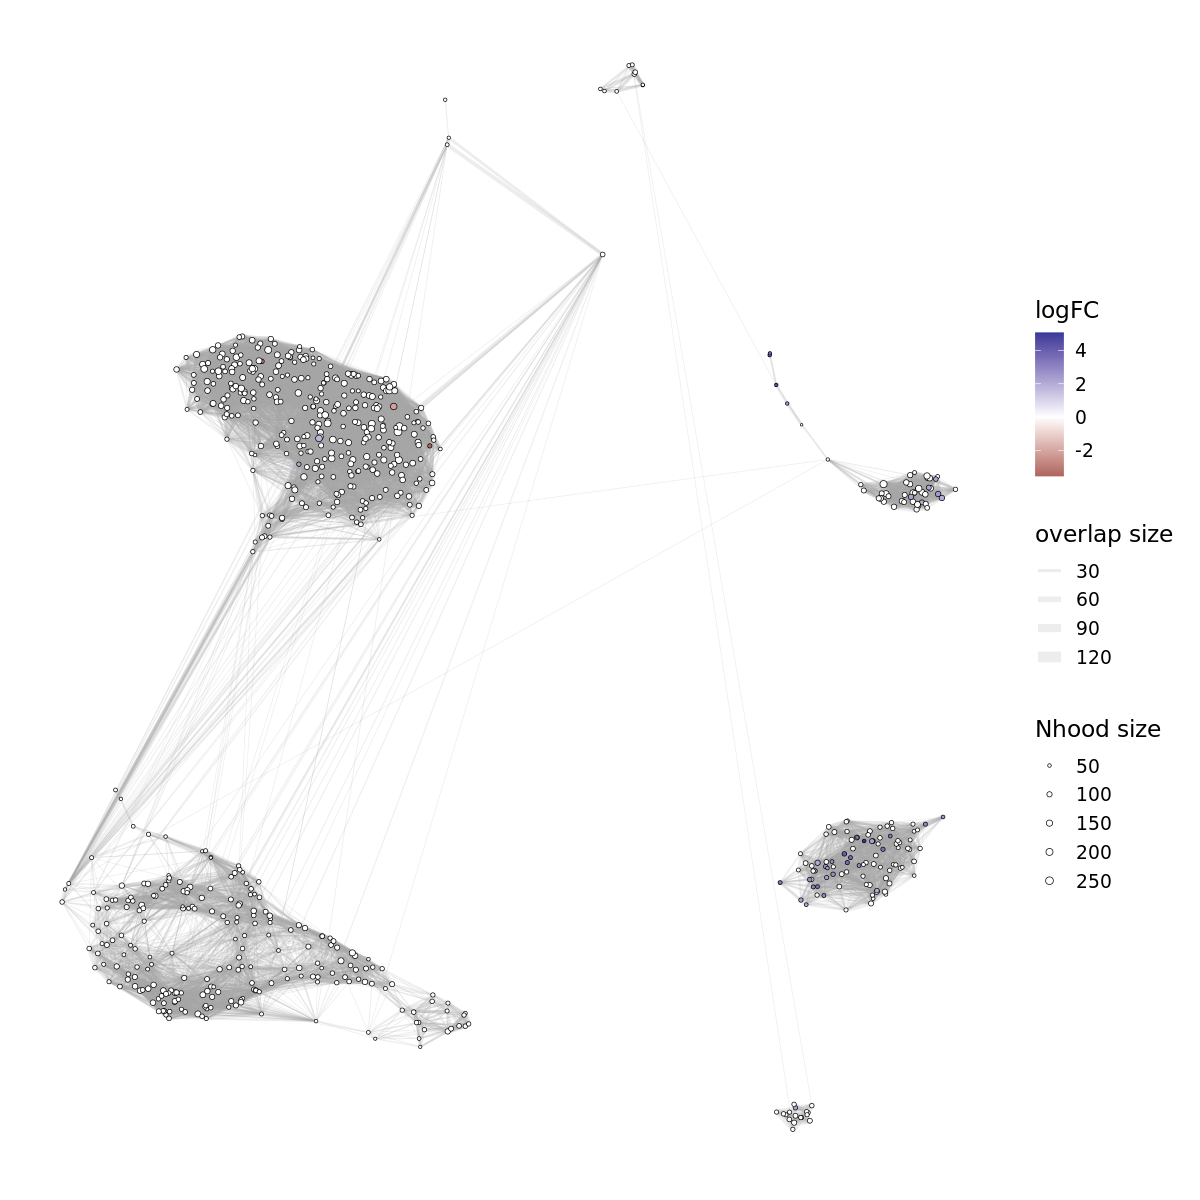

In [50]:
plotNhoodGraphDA(milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2), ) 

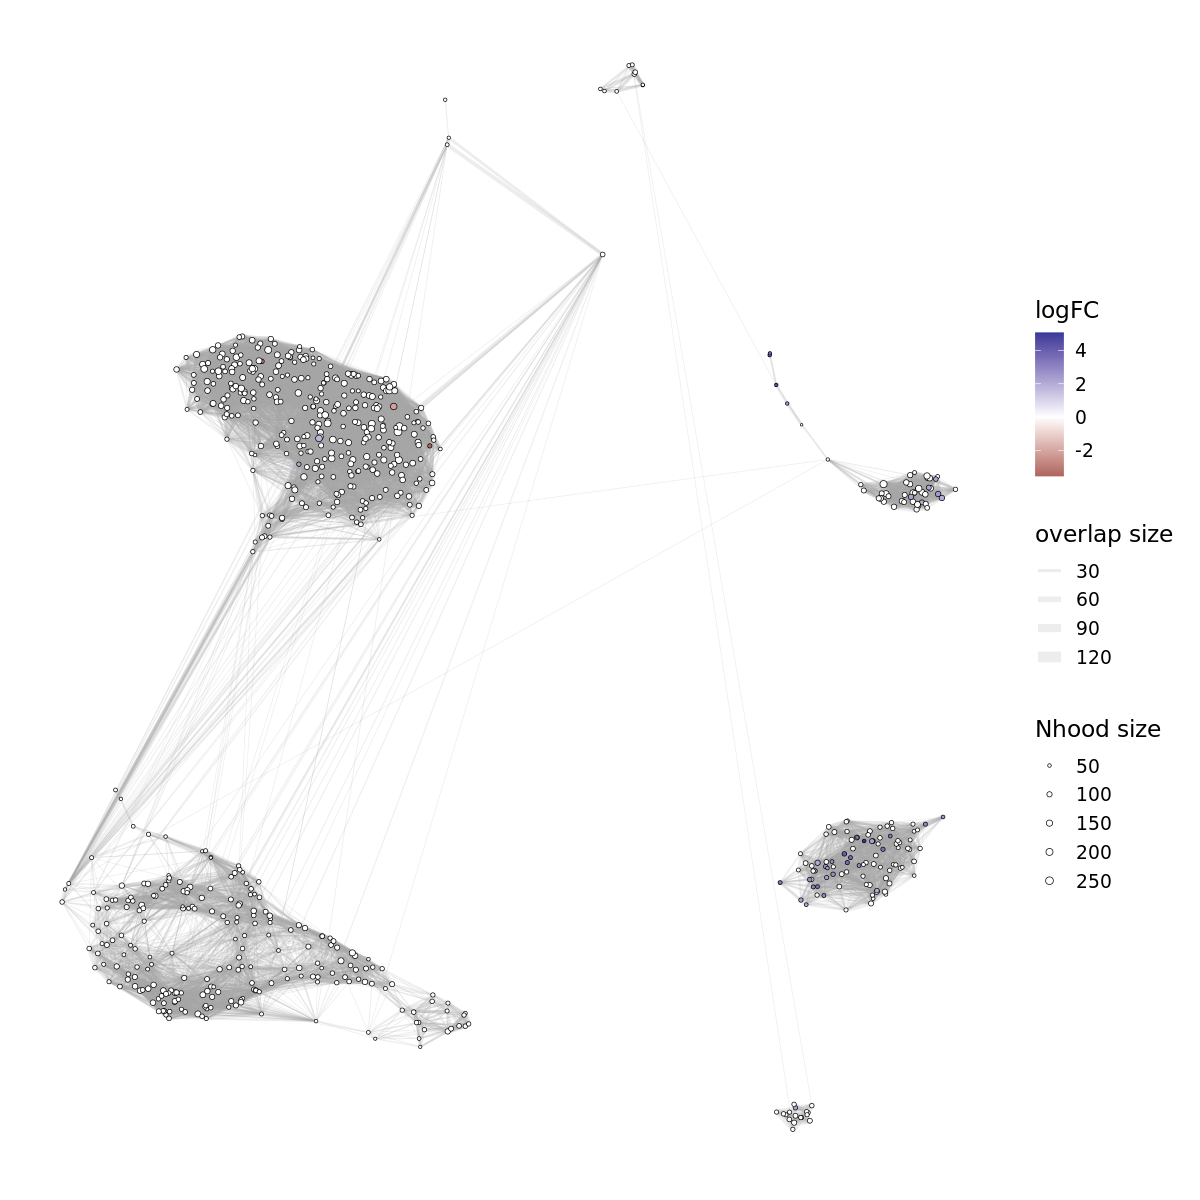

In [51]:
options(repr.plot.width=10, repr.plot.height=10)
plotNhoodGraphDA(milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2)) 

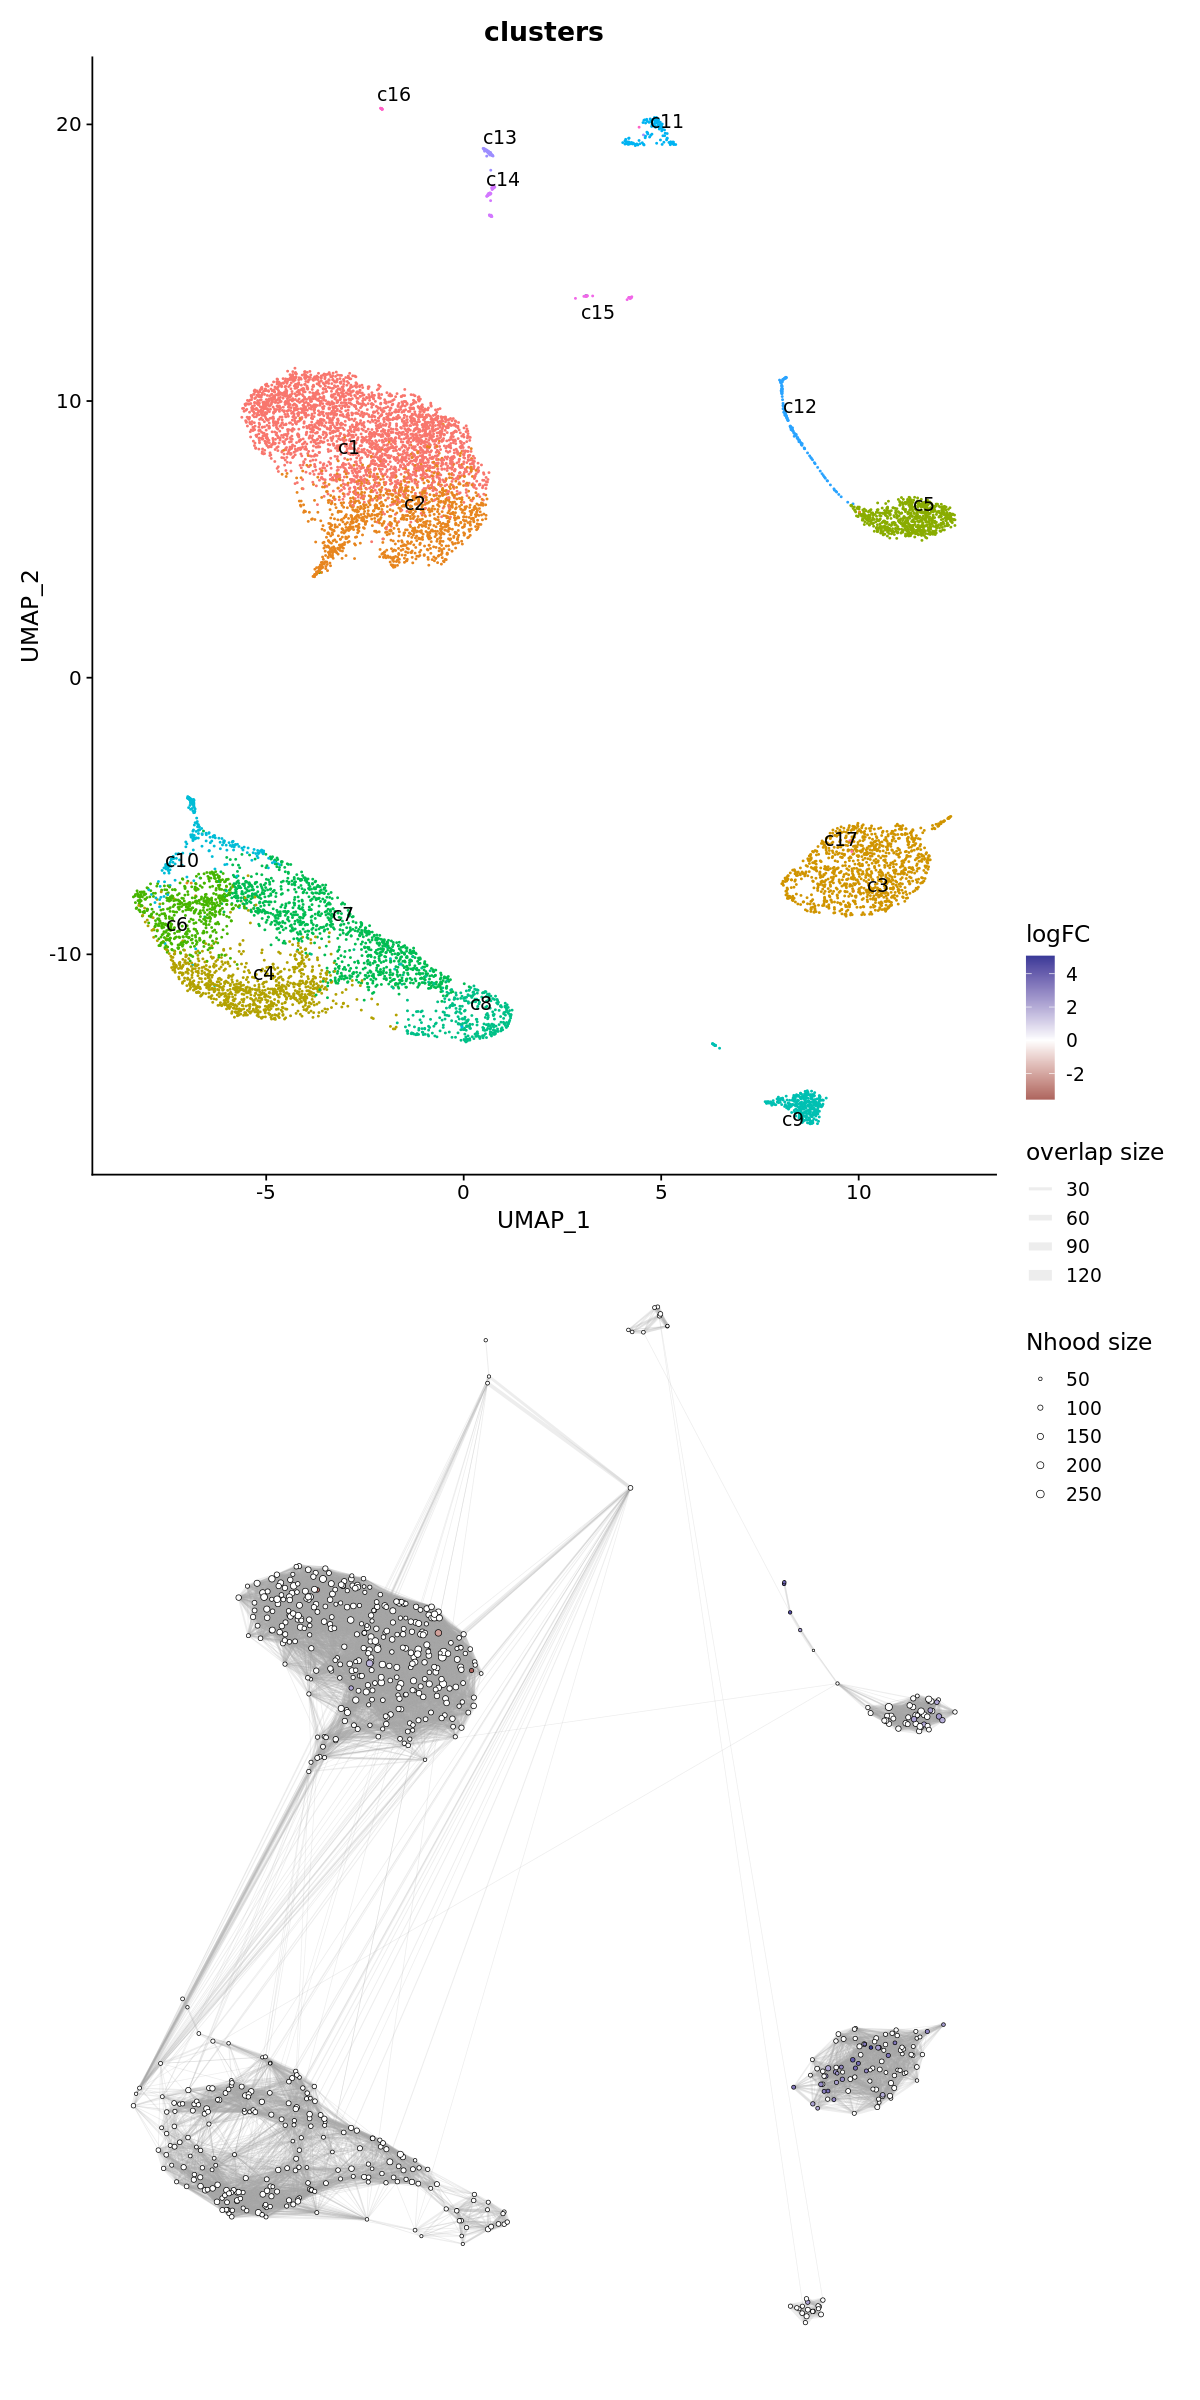

In [52]:
options(repr.plot.width=10, repr.plot.height=20)
umap_plot / nh_graph_pl +
  plot_layout(guides="collect")

In [53]:
da_results <- annotateNhoods(milo, da_results, coldata_col = "clusters")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,clusters,clusters_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,1.2668169,11.44939,4.8330027,0.02876111,0.2016097,1,0.2138201,c1,0.96
2,0.8304836,11.03147,1.5362495,0.21625559,0.4666553,2,0.4436596,c8,1.00
3,-0.5813879,11.27359,0.7800646,0.37790018,0.6327837,3,0.6082749,c1,1.00
4,-0.3391852,11.64993,0.3125409,0.57658448,0.7495598,4,0.7337961,c1,1.00
5,-1.5663340,11.27042,4.5556107,0.03370390,0.2180301,5,0.2221348,c2,1.00
6,-0.6987044,11.70929,1.3091231,0.25355791,0.5150395,6,0.4931959,c5,1.00


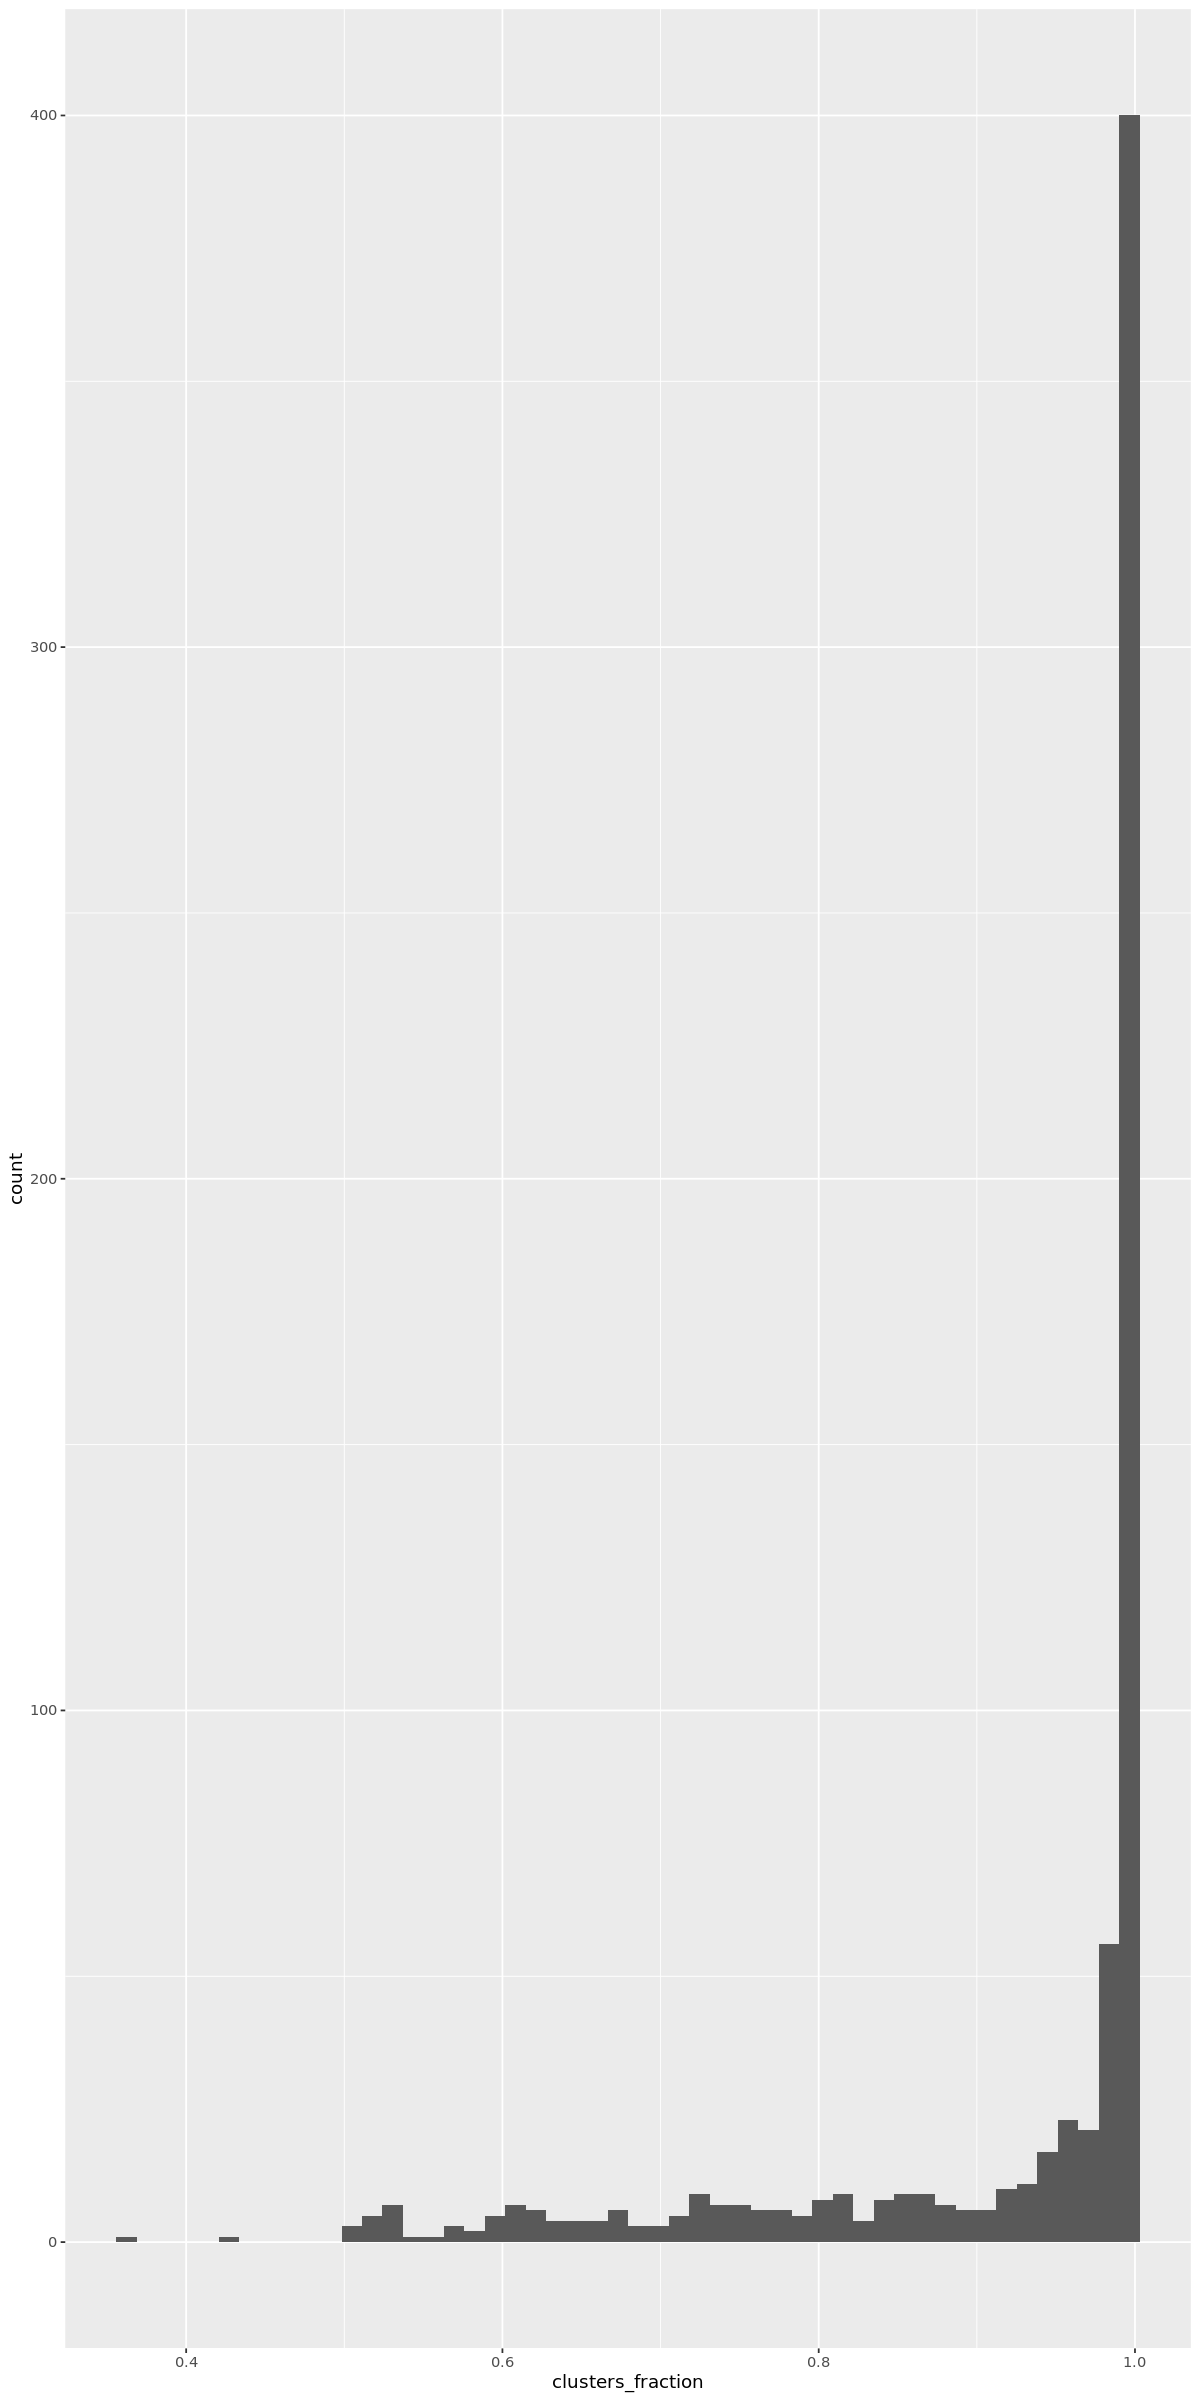

In [54]:
#we want to set a threshold to exclude neighbourhoods with a mix of cell types
ggplot(da_results, aes(clusters_fraction)) + geom_histogram(bins=50)

In [55]:
da_results$clusters <- ifelse(da_results$clusters_fraction < 0.7, "Mixed", da_results$clusters)

In [56]:
all_nhood = da_results %>%
group_by(clusters) %>% 
summarise(n = n()) %>%
arrange(desc(n))

sig_nhood = da_results %>%
mutate(across("clusters", as.factor)) %>%
filter(.[['SpatialFDR']] < 0.1) %>%
group_by(clusters, .drop=FALSE) %>% 
summarise(n = n()) %>%
arrange(desc(n)) %>%
rename("significant" = "n")


sig_up = da_results %>%
mutate(across("clusters", as.factor)) %>%
filter(.[['SpatialFDR']] < 0.1) %>%
filter(.[['logFC']] > 0) %>%
group_by(clusters, .drop=FALSE) %>% 
summarise(n = n()) %>%
arrange(desc(n)) %>%
rename("up" = "n") %>%
tidyr::complete()

sig_down = da_results %>%
mutate(across("clusters", as.factor)) %>%
filter(.[['SpatialFDR']] < 0.1) %>%
filter(.[['logFC']] < 0) %>%
group_by(clusters, .drop=FALSE) %>% 
summarise(n = n()) %>%
arrange(desc(n)) %>%
rename("down" = "n") %>%
tidyr::complete()

nhood_summary = plyr::join_all(list(all_nhood, sig_nhood, sig_up, sig_down), by = 'clusters')
nhood_summary = nhood_summary %>% arrange(n)
# nhood_summary = nhood_summary %>% arrange(significant)
nhood_summary$clusters = factor(nhood_summary$clusters, levels=nhood_summary$clusters)
nhood_summary = nhood_summary %>% tidyr::pivot_longer(c("up", "down"), names_to="direction", values_to="n_nhoods")

In [57]:
dput(levels(nhood_summary$clusters))

c("c13", "c14", "c12", "c10", "c11", "c9", "c8", "c6", "c5", 
"c2", "Mixed", "c4", "c7", "c3", "c1")


In [58]:
da_results$clusters = factor(da_results$clusters, levels=levels(nhood_summary$clusters))

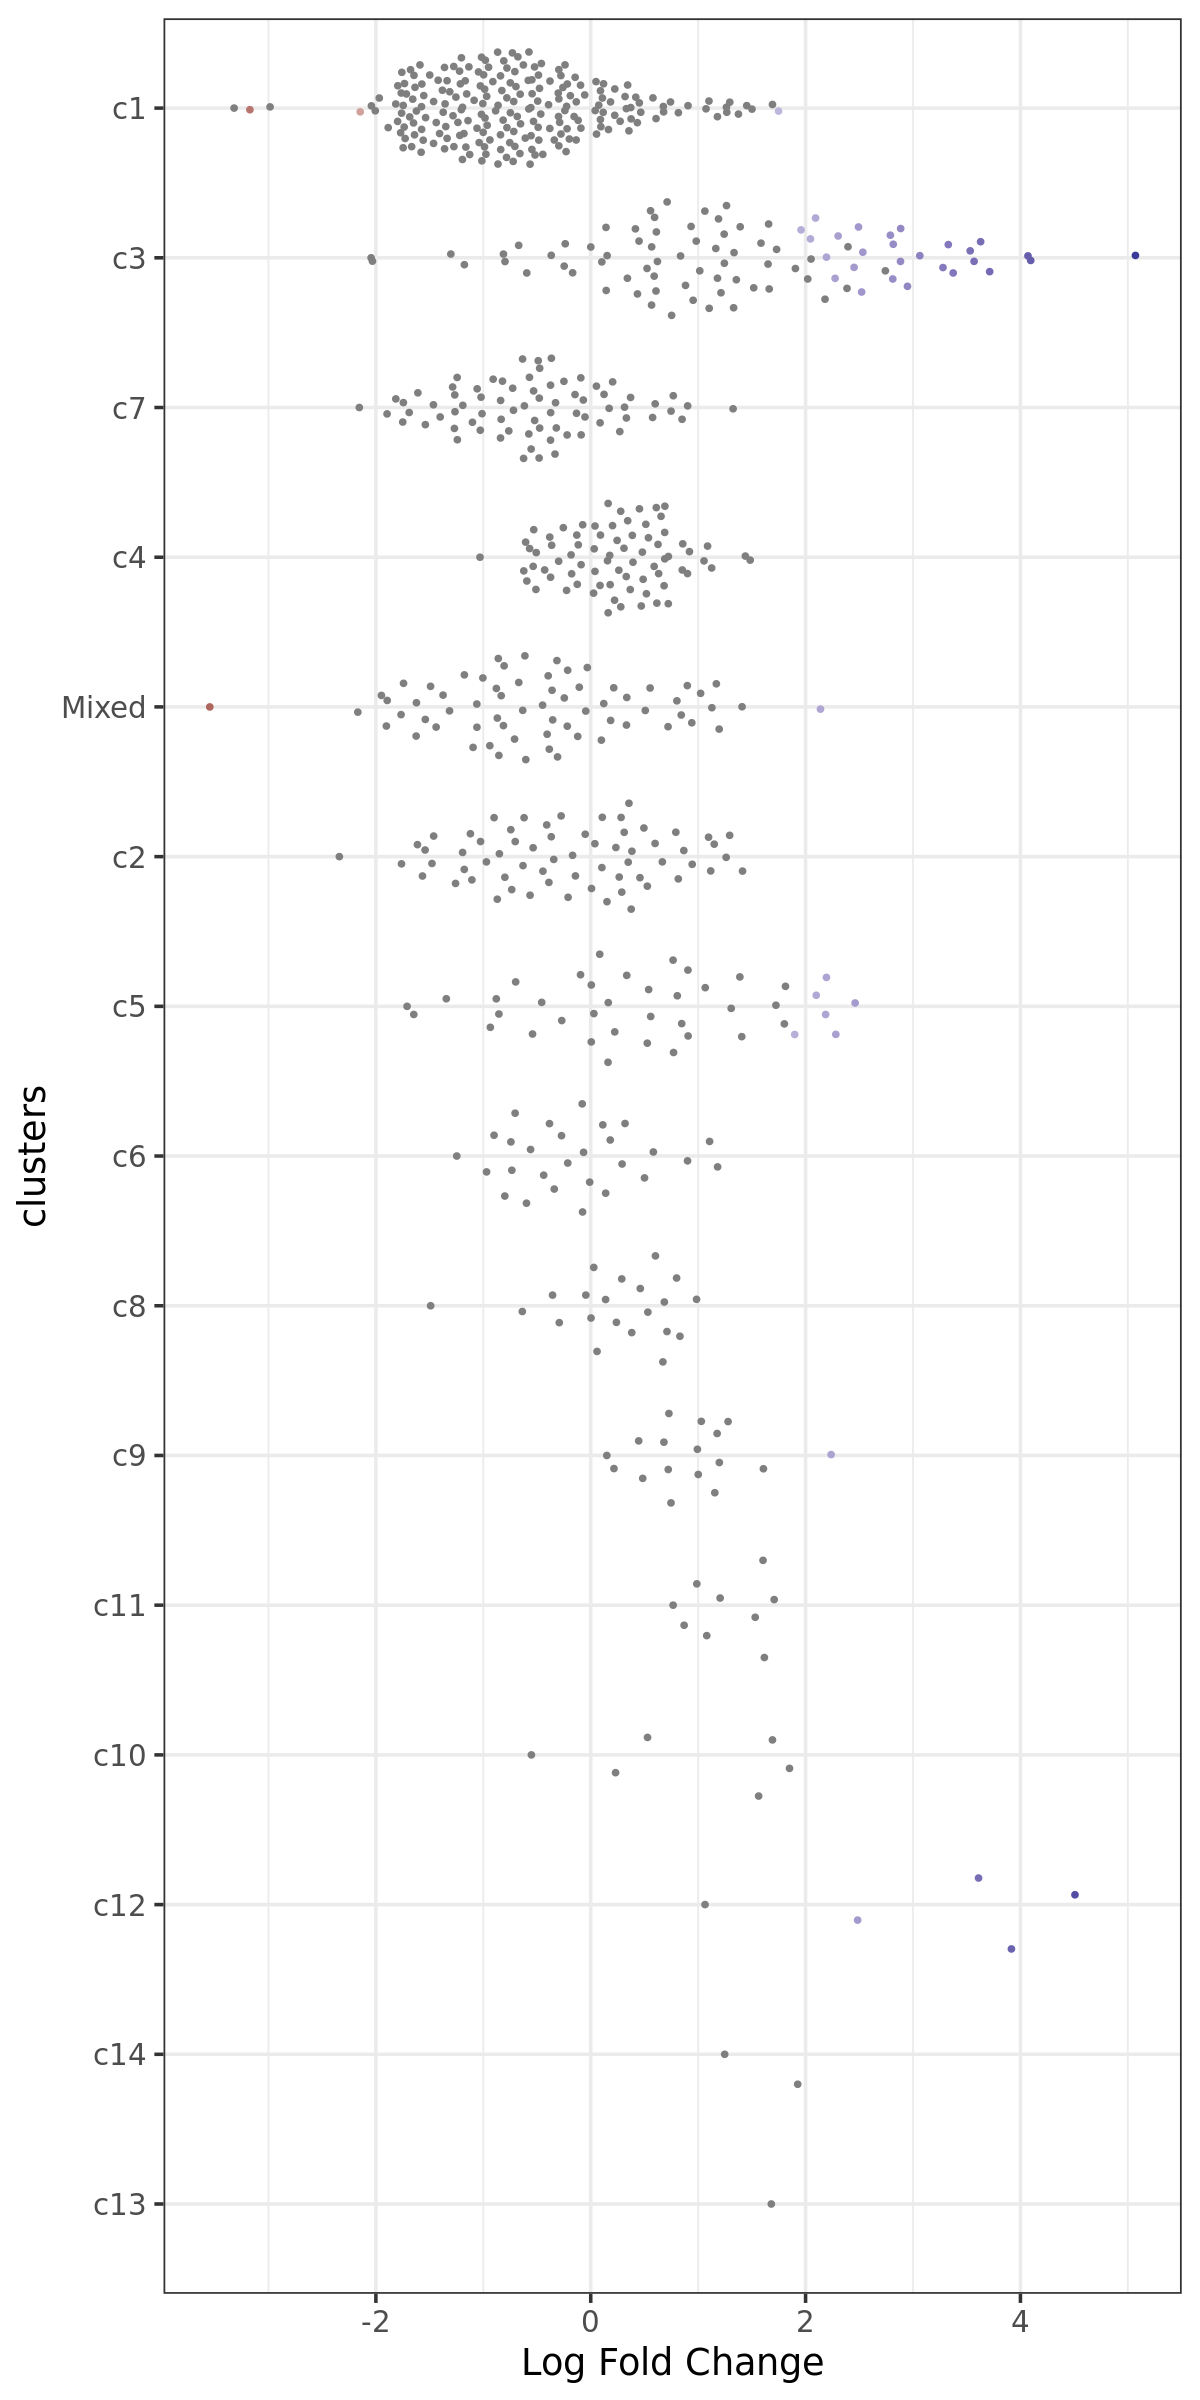

In [59]:
options(repr.plot.width=10, repr.plot.height=20)
pdab = plotDAbeeswarm(da_results, group.by = "clusters", )
pdab

In [60]:
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,clusters,clusters_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,1.2668169,11.44939,4.8330027,0.02876111,0.2016097,1,0.2138201,c1,0.96
2,0.8304836,11.03147,1.5362495,0.21625559,0.4666553,2,0.4436596,c8,1.00
3,-0.5813879,11.27359,0.7800646,0.37790018,0.6327837,3,0.6082749,c1,1.00
4,-0.3391852,11.64993,0.3125409,0.57658448,0.7495598,4,0.7337961,c1,1.00
5,-1.5663340,11.27042,4.5556107,0.03370390,0.2180301,5,0.2221348,c2,1.00
6,-0.6987044,11.70929,1.3091231,0.25355791,0.5150395,6,0.4931959,c5,1.00


In [63]:
## Exclude zero counts genes
keep.rows <- rowSums(logcounts(milo)) != 0
milo <- milo[keep.rows, ]

## Find HVGs
set.seed(101)
dec <- scran::modelGeneVar(milo)
hvgs <- scran::getTopHVGs(dec, n=3000)
head(hvgs)

[1] "Gpc5"   "Trpm3"  "Ntm"    "Kcnd2"  "Nkain2" "Slit2"

In [64]:
## Run buildNhoodGraph to store nhood adjacency matrix
milo <- buildNhoodGraph(milo)

## Find groups
da_results <- groupNhoods(milo, da_results, max.lfc.delta = 2)
head(da_results)

Found 43 DA neighbourhoods at FDR 10%

nhoodAdjacency found - using for nhood grouping



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,clusters,clusters_fraction,NhoodGroup
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<chr>
1,1.2668169,11.44939,4.8330027,0.02876111,0.2016097,1,0.2138201,c1,0.96,1
2,0.8304836,11.03147,1.5362495,0.21625559,0.4666553,2,0.4436596,c8,1.00,2
3,-0.5813879,11.27359,0.7800646,0.37790018,0.6327837,3,0.6082749,c1,1.00,1
4,-0.3391852,11.64993,0.3125409,0.57658448,0.7495598,4,0.7337961,c1,1.00,3
5,-1.5663340,11.27042,4.5556107,0.03370390,0.2180301,5,0.2221348,c2,1.00,3
6,-0.6987044,11.70929,1.3091231,0.25355791,0.5150395,6,0.4931959,c5,1.00,4


In [65]:
da_results$NhoodGroup %>% unique

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10"

Converting group.by to factor...



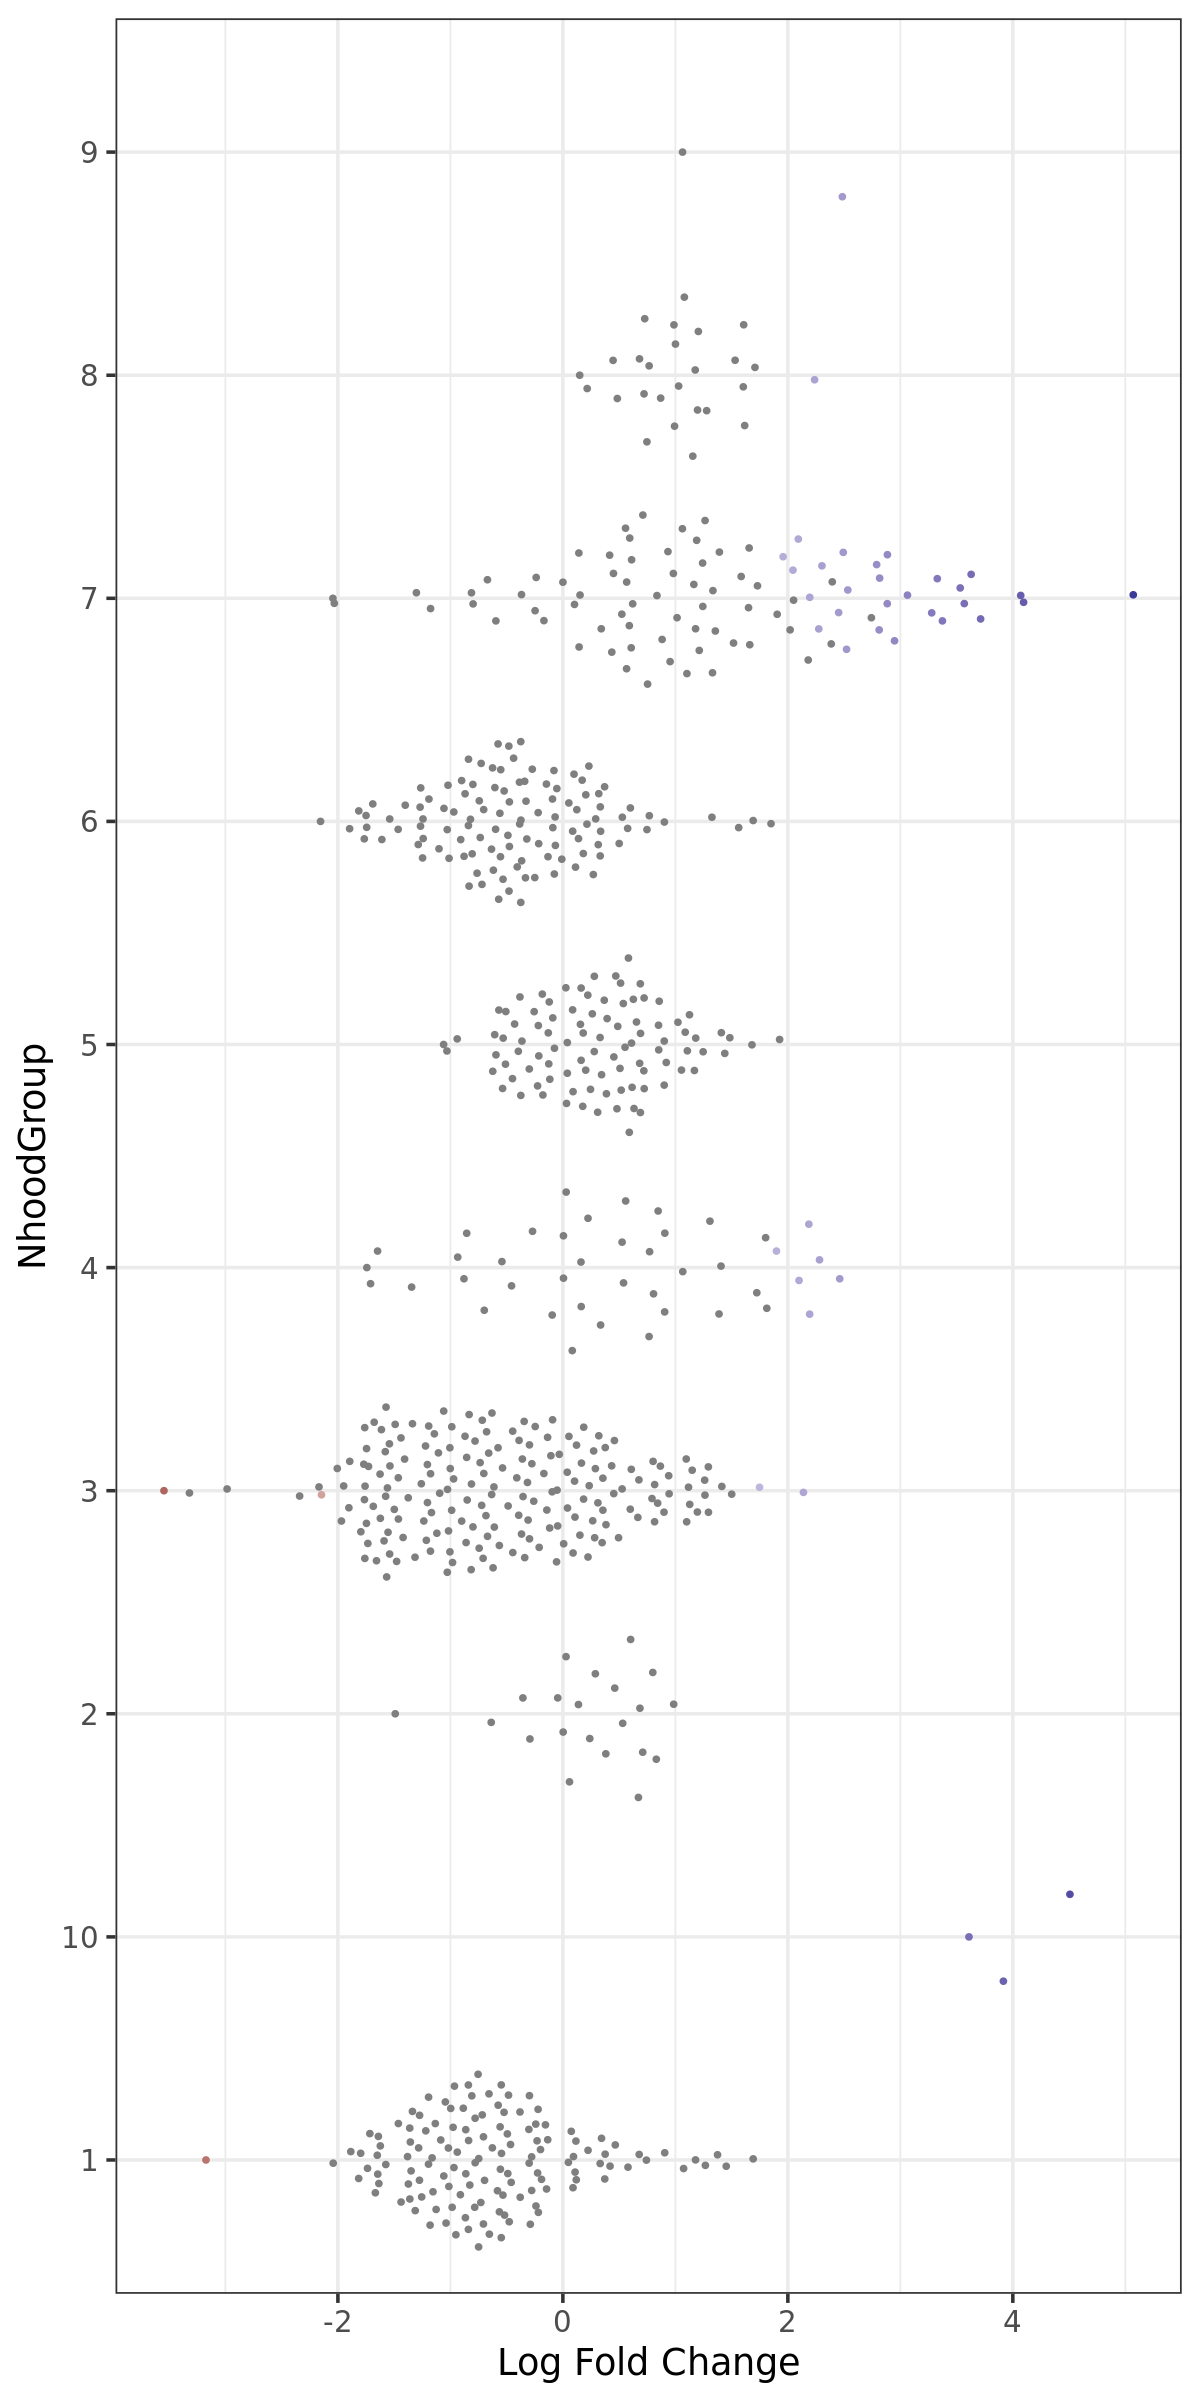

In [66]:
options(repr.plot.width=10, repr.plot.height=20)
pdab = plotDAbeeswarm(da_results, group.by = "NhoodGroup", )
pdab

In [72]:
degs = testDiffExp(milo,
            da_results,
            design = ~ group + batch,
            meta.data = data.frame(colData(milo)),
            subset.row = hvgs, 
            subset.nhoods=da_results$NhoodGroup=="7")
head(degs[['7']])



Warning message:
“Zero sample variances detected, have been offset away from zero”


,logFC,AveExpr,t,P.Value,adj.P.Val,B,Nhood.Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Mapk4,-0.1605061,0.1160998,-7.632132,5.054716e-14,1.332333e-10,21.17888,7
Sox6,-0.2027177,0.1947990,-7.555224,8.882217e-14,1.332333e-10,20.64108,7
Lhfp,-0.1454374,0.1057362,-7.132788,1.797843e-12,1.797843e-09,17.77457,7
Rorb,-0.1780503,0.1416003,-6.963523,5.750373e-12,4.312780e-09,16.66796,7
Plce1,-0.1451249,0.1189694,-6.709744,3.138993e-11,1.597194e-08,15.05430,7
Glis3,-0.1369445,0.1062969,-6.707084,3.194388e-11,1.597194e-08,15.03768,7


In [74]:
degs = testDiffExp(milo,
            da_results,
            design = model,
            model.contrasts = c("groupP1.T1.S1-groupP0.T1.S1"),
            meta.data = data.frame(colData(milo)),
            subset.row = hvgs, 
            subset.nhoods=da_results$NhoodGroup=="7")
head(degs[['7']])



Subsetting input design matrix to DA neighbourhood cells



ERROR: Error in testDiffExp(milo, da_results, design = model, model.contrasts = c("groupP1.T1.S1-groupP0.T1.S1"), : Cannot subset model matrix, subsetting vector is wrong length:10000


In [76]:
degs = testDiffExp(milo,
            da_results,
            design = ~ group + batch,
            model.contrasts = c("groupP1.T1.S1-groupP0.T1.S1"),
            meta.data = data.frame(colData(milo)),
            subset.row = hvgs, 
            subset.nhoods=da_results$NhoodGroup=="7")
head(degs[['7']])



Warning message in makeContrasts(contrasts = model.contrasts, levels = test.model):
“Renaming (Intercept) to Intercept”
Warning message in contrasts.fit(i.fit, contrasts = mod.constrast):
“row names of contrasts don't match col names of coefficients”
Warning message:
“Zero sample variances detected, have been offset away from zero”


,logFC,AveExpr,t,P.Value,adj.P.Val,B,Nhood.Group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Tmeff2,0.4601073,3.731393,7.386985,2.996247e-13,8.988741e-10,19.143727,7
Nkain2,0.2609590,4.602026,6.936323,6.915871e-12,1.037381e-08,16.228515,7
Ptprd,0.2915797,3.796930,6.307231,4.133479e-10,4.133479e-07,12.439781,7
Ptgds,-0.5282174,1.143131,-6.129204,1.235700e-09,9.267752e-07,11.427957,7
Gli2,-0.3215046,0.237269,-6.000337,2.683173e-09,1.609904e-06,10.712335,7
Cdh20,0.6310181,1.926903,5.748360,1.171405e-08,5.857027e-06,9.354099,7


In [77]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux

Matrix products: default
BLAS/LAPACK: /nfsdata/tools/anaconda/envs/nmq407/fgf1/lib/libopenblasp-r0.3.20.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C               LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8    LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C             LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Seurat_4.1.1.9002           sp_1.5-0                    SeuratObject_4.1.0          patchwork_1.1.1            
 [5] dplyr_1.0.9                 scater_1.25.5               ggplot2_3.3.6               scuttle_1.4.0              
 [9] SingleCellExperiment_1.16.0 SummarizedExperiment_1.24.0 Bio